<a href="https://colab.research.google.com/github/gazal-gupta/Machine_Learning/blob/master/Project_1_Trial_v_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consumer Complaints Resolution

Introduction :- 
Consumer complaint resolution is important to any business. In this particular case we have been given detailed
consumer complaints along with whether consumer disputed with the conclusion. If we are able to predict this, consumer who is more likely to dispute a conclusion can be given more attention as to how the complaints are
handled as well as how persuasively the final conlusions are conveyed to them.
Your target here is to build prediction model for column "Consumer disputed".

Formal Problem Statement ¶
Your target here is to build prediction model so that you are able to predict which consumer is more likely to
dispute the resolution of a complaint i.e. you need to make predictions for the "Consumer disputed" column.
All the column names are self explanatory. You need to build your model on train data. Test data does not have
the response column "Consumer disputed", you need to predict those values and submit it in a csv format.

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as mso
import datetime as datetime
import calendar
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.model_selection import KFold , RandomizedSearchCV,train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score , precision_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.metrics import fbeta_score

In [0]:
#Now let's import and put the train and test datasets in  pandas dataframe

file1 = "/Users/1535/OneDrive - Xceedance Consulting India Private Ltd/Gazal Xceedance/EDV/Python/Python Projects/Project 1/Consumer_Complaints_train.csv"
train=pd.read_csv(file1)

file2 = "/Users/1535/OneDrive - Xceedance Consulting India Private Ltd/Gazal Xceedance/EDV/Python/Python Projects/Project 1/Consumer_Complaints_test_share.csv"
test=pd.read_csv(file2)


Making the target variable i.e Consumer disputed? numeric
As the data is imbalanced, we need to do undersampling

Class 0: 376990
Class 1: 101431
Proportion: 3.72 : 1


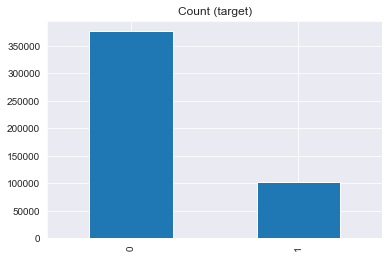

In [0]:
train['Consumer disputed?'] = np.where(train['Consumer disputed?'] == 'Yes',1,0)
target_count = train['Consumer disputed?'].value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [0]:
# Class count
count_class_0, count_class_1 = train['Consumer disputed?'].value_counts()

# Divide by class
class_0 = train[train['Consumer disputed?'] == 0]
class_1 = train[train['Consumer disputed?'] == 1]

Random under-sampling

Random under-sampling:
1    101431
0    101431
Name: Consumer disputed?, dtype: int64


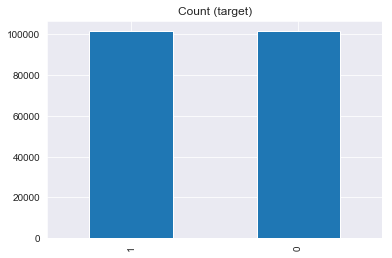

In [0]:
class_0_under = class_0.sample(count_class_1)
train_under = pd.concat([class_0_under, class_1], axis=0)

print('Random under-sampling:')
print(train_under['Consumer disputed?'].value_counts())

train_under['Consumer disputed?'].value_counts().plot(kind='bar', title='Count (target)');

In [0]:
# combine the two datasets to pre-process the data together since the data on which the model is trained should
# undergo the same preprocessing as the data on which the predictions are made

train_under['data'] = 'Train'
test['data'] = 'Test'

test['Consumer disputed?'] = np.nan
train_under.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [0]:
train_under.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,data
0,2014-03-26,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,HSBC North America Holdings Inc.,NJ,08080,NaN,NaN,Referral,2014-04-01,Closed with explanation,Yes,0,778911,Train
1,2014-07-02,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt was paid,NaN,NaN,"Expert Global Solutions, Inc.",TX,76009,NaN,NaN,Web,2014-07-08,Closed with explanation,Yes,0,921600,Train
2,2014-04-22,Credit card,NaN,Other,NaN,NaN,NaN,Discover,FL,33433,NaN,NaN,Web,2014-04-22,Closed with explanation,Yes,0,818394,Train
3,2015-09-23,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Ocwen,OH,44105,NaN,NaN,Referral,2015-09-28,Closed with explanation,Yes,0,1576750,Train
4,2012-08-31,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,CA,95630,NaN,NaN,Web,2012-08-31,Closed with explanation,Yes,0,145440,Train


In [0]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train_under.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (202862, 19) 
The test data size before dropping Id feature is : (119606, 19) 


In [0]:
test=test[train_under.columns] # the columns in the two data frames should be in the same order to enable concatenation

cd_all=pd.concat([train_under,test],axis=0)

cd_all.reset_index(drop=True,inplace=True)

In [0]:
cd_all.shape

(322468, 19)

In [0]:
cd_all.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,data
0,2014-03-26,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,HSBC North America Holdings Inc.,NJ,08080,NaN,NaN,Referral,2014-04-01,Closed with explanation,Yes,0.0,778911,Train
1,2014-07-02,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt was paid,NaN,NaN,"Expert Global Solutions, Inc.",TX,76009,NaN,NaN,Web,2014-07-08,Closed with explanation,Yes,0.0,921600,Train
2,2014-04-22,Credit card,NaN,Other,NaN,NaN,NaN,Discover,FL,33433,NaN,NaN,Web,2014-04-22,Closed with explanation,Yes,0.0,818394,Train
3,2015-09-23,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Ocwen,OH,44105,NaN,NaN,Referral,2015-09-28,Closed with explanation,Yes,0.0,1576750,Train
4,2012-08-31,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,CA,95630,NaN,NaN,Web,2012-08-31,Closed with explanation,Yes,0.0,145440,Train


In [0]:
cd_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322468 entries, 0 to 322467
Data columns (total 19 columns):
Date received                   322468 non-null object
Product                         322468 non-null object
Sub-product                     230854 non-null object
Issue                           322468 non-null object
Sub-issue                       122185 non-null object
Consumer complaint narrative    52469 non-null object
Company public response         60507 non-null object
Company                         322468 non-null object
State                           319979 non-null object
ZIP code                        319974 non-null object
Tags                            45947 non-null object
Consumer consent provided?      93034 non-null object
Submitted via                   322467 non-null object
Date sent to company            322468 non-null object
Company response to consumer    322468 non-null object
Timely response?                322468 non-null object
Consumer disp

In [0]:
cd_all.dtypes

Date received                    object
Product                          object
Sub-product                      object
Issue                            object
Sub-issue                        object
Consumer complaint narrative     object
Company public response          object
Company                          object
State                            object
ZIP code                         object
Tags                             object
Consumer consent provided?       object
Submitted via                    object
Date sent to company             object
Company response to consumer     object
Timely response?                 object
Consumer disputed?              float64
Complaint ID                      int64
data                             object
dtype: object

In [0]:
print(cd_all['ZIP code'].unique()) # gives the unique values in the column
print(cd_all['ZIP code'].nunique()) # gives the number of unique values

['08080' '76009' '33433' ... '36831' '19093' '49544']
23248


In [0]:
#Now drop the  'Complaint ID' colum since it's unnecessary for  the prediction process.
cd_all.drop("Complaint ID", axis = 1, inplace = True)

#It doesnt make sense to use ZIP CODES as a numeric variable.
cd_all.drop("ZIP code", axis = 1, inplace = True)

cd_all.shape

(322468, 17)

# Missing Data

In [0]:
all_data_na = (cd_all.isnull().sum() / len(cd_all)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
Tags,85.751454
Consumer complaint narrative,83.728928
Company public response,81.236278
Consumer consent provided?,71.149385
Sub-issue,62.109419
Consumer disputed?,37.090812
Sub-product,28.410261
State,0.771860
Submitted via,0.000310


In [0]:
for col in ['Date received','Date sent to company']:
    cd_all[col]=pd.to_datetime(cd_all[col],infer_datetime_format=True)

In [0]:
#Date difference taken and converted into acutal numbers

cd_all['day_diff']=cd_all['Date sent to company']-cd_all['Date received']
cd_all['day_diff'] / pd.Timedelta(1, unit='d')
cd_all['day_diff'] = cd_all['day_diff'].astype('timedelta64[D]')

In [0]:
#Extract weekday from the Date
#Converting the Weekdays into numeric
cd_all["WeekdaySent"] = cd_all['Date sent to company'].dt.day_name()
cd_all["WeekdaySent"] = pd.Categorical(cd_all["WeekdaySent"])
cd_all["WeekdaySent"] = cd_all["WeekdaySent"].cat.codes

cd_all["WeekdayReceived"] = cd_all['Date received'].dt.day_name()
cd_all["WeekdayReceived"] = pd.Categorical(cd_all["WeekdayReceived"])
cd_all["WeekdayReceived"] = cd_all["WeekdayReceived"].cat.codes



In [0]:
#Extract Month from the Date
cd_all["MonthReceived"] = cd_all['Date received'].dt.month_name()
cd_all['MonthSent'] = cd_all['Date sent to company'].dt.month_name()

#Converting the Months into numeric

cd_all["MonthReceived"] = pd.Categorical(cd_all["MonthReceived"])
cd_all["MonthReceived"] = cd_all["MonthReceived"].cat.codes

cd_all['MonthSent'] = pd.Categorical(cd_all['MonthSent'])
cd_all['MonthSent'] = cd_all['MonthSent'].cat.codes

In [0]:
cd_all[["MonthReceived",'MonthSent',"WeekdaySent","WeekdayReceived"]].head()

,MonthReceived,MonthSent,WeekdaySent,WeekdayReceived
0,7,0,5,6
1,5,5,5,6
2,0,0,5,5
3,11,11,1,6
4,1,1,0,0


In [0]:
cd_all.drop(['Date received','Date sent to company'],1,inplace=True)

Convert Weekday and Month column into Cyclic features

In [0]:
def code_cyclic_features(data,columns,drop_cols=True):
    for col in columns:
        max_val=max(data[col])

        data[col+'_sin']=np.sin(2*np.pi*data[col]/max_val)
        data[col+'_cos']=np.cos(2*np.pi*data[col]/max_val)

        if drop_cols:
            del data[col]
    return data  

In [0]:
Convert_cyclic = ["MonthReceived",'MonthSent',"WeekdaySent","WeekdayReceived"]

In [0]:
code_cyclic_features(cd_all,Convert_cyclic)

,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,Tags,Consumer consent provided?,...,data,day_diff,MonthReceived_sin,MonthReceived_cos,MonthSent_sin,MonthSent_cos,WeekdaySent_sin,WeekdaySent_cos,WeekdayReceived_sin,WeekdayReceived_cos
0,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,HSBC North America Holdings Inc.,NJ,NaN,NaN,...,Train,6.0,-7.557496e-01,-0.654861,0.000000e+00,1.000000,-8.660254e-01,0.5,-2.449294e-16,1.0
1,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt was paid,NaN,NaN,"Expert Global Solutions, Inc.",TX,NaN,NaN,...,Train,6.0,2.817326e-01,-0.959493,2.817326e-01,-0.959493,-8.660254e-01,0.5,-2.449294e-16,1.0
2,Credit card,NaN,Other,NaN,NaN,NaN,Discover,FL,NaN,NaN,...,Train,0.0,0.000000e+00,1.000000,0.000000e+00,1.000000,-8.660254e-01,0.5,-8.660254e-01,0.5
3,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Ocwen,OH,NaN,NaN,...,Train,5.0,-1.133108e-15,1.000000,-1.133108e-15,1.000000,8.660254e-01,0.5,-2.449294e-16,1.0
4,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,CA,NaN,NaN,...,Train,0.0,5.406408e-01,0.841254,5.406408e-01,0.841254,0.000000e+00,1.0,0.000000e+00,1.0
5,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",FL,NaN,NaN,...,Train,1.0,9.096320e-01,0.415415,9.096320e-01,0.415415,-8.660254e-01,-0.5,-2.449294e-16,1.0
6,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,NY,NaN,NaN,...,Train,0.0,0.000000e+00,1.000000,0.000000e+00,1.000000,-8.660254e-01,0.5,-8.660254e-01,0.5
7,Credit reporting,NaN,Incorrect information on credit report,Account status,It 's concerning the XXXX auto payment closed ...,NaN,Equifax,CO,NaN,Consent provided,...,Train,0.0,2.817326e-01,-0.959493,2.817326e-01,-0.959493,8.660254e-01,0.5,8.660254e-01,0.5
8,Debt collection,I do not know,Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,Blueshore Recovery,MN,NaN,NaN,...,Train,4.0,-2.817326e-01,-0.959493,-2.817326e-01,-0.959493,8.660254e-01,0.5,-8.660254e-01,-0.5
9,Credit card,NaN,Payoff process,NaN,NaN,NaN,Wells Fargo & Company,CA,NaN,NaN,...,Train,6.0,-7.557496e-01,-0.654861,-7.557496e-01,-0.654861,-8.660254e-01,0.5,-2.449294e-16,1.0


In [0]:
for col in cd_all.select_dtypes(['object']).columns:
    print(col,':',cd_all[col].nunique())

Product : 12
Sub-product : 47
Issue : 95
Sub-issue : 67
Consumer complaint narrative : 51918
Company public response : 10
Company : 2953
State : 62
Tags : 3
Consumer consent provided? : 4
Submitted via : 6
Company response to consumer : 7
Timely response? : 2
data : 2


In [0]:
cd_all.isnull().sum()

Product                              0
Sub-product                      91614
Issue                                0
Sub-issue                       200283
Consumer complaint narrative    269999
Company public response         261961
Company                              0
State                             2489
Tags                            276521
Consumer consent provided?      229434
Submitted via                        1
Company response to consumer         0
Timely response?                     0
Consumer disputed?              119606
data                                 0
day_diff                             0
MonthReceived_sin                    0
MonthReceived_cos                    0
MonthSent_sin                        0
MonthSent_cos                        0
WeekdaySent_sin                      0
WeekdaySent_cos                      0
WeekdayReceived_sin                  0
WeekdayReceived_cos                  0
dtype: int64

Checking 'Timely Response'

In [0]:
cd_all['Timely response?'].value_counts()

Yes    317134
No       5334
Name: Timely response?, dtype: int64

In [0]:
cd_all['Timely response?'].isnull().sum()

0

In [0]:
cd_all['Timely response?'] = np.where(cd_all['Timely response?'] == 'Yes',1,0)

Replace 'Consumer complaint narrative' as None. This will help to understand whether customer gave any feedback for disputed raised

In [0]:
cd_all['Consumer complaint narrative'].isnull().sum()

269999

In [0]:
cd_all['Consumer complaint narrative'] = cd_all['Consumer complaint narrative'].fillna("None")

In [0]:
cd_all['Consumer complaint narrative'].isnull().sum()

0

In [0]:
for col in cd_all.select_dtypes(['object']).columns:
    cd_all[col].fillna("None")

In [0]:
print(cd_all['Submitted via'].value_counts())
print('------------------------------')
print('Submitted via_Null values are' , cd_all['Submitted via'].isnull().sum())

Web            216088
Referral        59439
Phone           22038
Postal mail     19899
Fax              4812
Email             191
Name: Submitted via, dtype: int64
------------------------------
Submitted via_Null values are 1


In [0]:
#replacing the NA value with the mode value 
cd_all['Submitted via'] = cd_all['Submitted via'].fillna(cd_all['Submitted via'].mode()[0])

In [0]:
print(cd_all['State'].value_counts())
print('------------------------------')
print('State_Null values are' , cd_all['State'].isnull().sum())

CA    47764
FL    31124
TX    23768
NY    22203
GA    14226
NJ    13082
IL    11534
PA    11468
VA    10780
MD    10304
OH    10009
NC     8952
MI     8360
AZ     7289
WA     6733
MA     6419
CO     5704
TN     4871
MO     4155
NV     4119
SC     3961
OR     3959
MN     3838
CT     3650
WI     3503
IN     3464
AL     3285
LA     3026
KY     2325
OK     2066
      ...  
UT     1691
NH     1577
NM     1571
KS     1503
MS     1491
AR     1321
IA     1307
HI     1144
RI     1110
ME     1108
ID     1077
NE     1044
WV      856
PR      787
VT      524
MT      524
SD      407
AK      357
WY      325
ND      257
AE      127
AP       95
VI       79
GU       44
FM       20
MH       12
MP       10
AS       10
AA        8
PW        5
Name: State, Length: 62, dtype: int64
------------------------------
State_Null values are 2489


In [0]:
#replacing the NA value with the mode value 
#cd_all['State'] = cd_all['State'].fillna(cd_all['State'].mode()[0])

In [0]:
for col in cd_all.select_dtypes(['object']).columns:
    print(col,':',cd_all[col].nunique())

Product : 12
Sub-product : 47
Issue : 95
Sub-issue : 67
Consumer complaint narrative : 51919
Company public response : 10
Company : 2953
State : 62
Tags : 3
Consumer consent provided? : 4
Submitted via : 6
Company response to consumer : 7
data : 2


In [0]:
cd_all['Company'].value_counts()

Bank of America                             31872
Wells Fargo & Company                       24534
JPMorgan Chase & Co.                        19882
Equifax                                     19802
Experian                                    16650
Citibank                                    15126
TransUnion Intermediate Holdings, Inc.      14522
Ocwen                                       12180
Capital One                                  8610
Nationstar Mortgage                          7892
U.S. Bancorp                                 5526
Synchrony Financial                          5148
Ditech Financial LLC                         5116
Navient Solutions, Inc.                      4917
PNC Bank N.A.                                3841
Amex                                         3809
Encore Capital Group                         3580
HSBC North America Holdings Inc.             3555
SunTrust Banks, Inc.                         2815
Discover                                     2792


In [0]:
cd_all['Tags'] = cd_all['Tags'].fillna("None")

In [0]:
print(cd_all['Tags'].value_counts())
print('------------------------------')
print('Tags_Null values are' , cd_all['Tags'].isnull().sum())


None                             276521
Older American                    26648
Servicemember                     15602
Older American, Servicemember      3697
Name: Tags, dtype: int64
------------------------------
Tags_Null values are 0


In [0]:
print(cd_all['Sub-product'].value_counts())
print('------------------------------')
print('Sub-product_Null values are' , cd_all['Sub-product'].isnull().sum())

Other mortgage                            41358
Conventional fixed mortgage               34041
Checking account                          25453
Other (i.e. phone, health club, etc.)     16875
Conventional adjustable mortgage (ARM)    12657
I do not know                             11940
Credit card                               11866
FHA mortgage                              11283
Non-federal student loan                  10132
Medical                                    7915
Vehicle loan                               7489
Other bank product/service                 6613
Home equity loan or line of credit         5592
Payday loan                                4934
Installment loan                           3298
Savings account                            2305
Mortgage                                   2194
VA mortgage                                2181
(CD) Certificate of deposit                1695
Auto                                       1419
International money transfer            

In [0]:
cd_all['Sub-product'] = cd_all['Sub-product'].fillna("None")

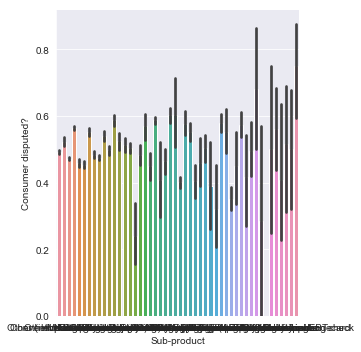

In [0]:
sns.catplot(x="Sub-product", y="Consumer disputed?", kind="bar", data=cd_all);

In [0]:
pd.crosstab(cd_all['Sub-product'],cd_all['Consumer disputed?'])

Consumer disputed?,0.0,1.0
Sub-product,,
(CD) Certificate of deposit,460,635
Auto,465,433
Cashing a check without an account,100,85
Check cashing,25,32
Checking account,8262,7470
Conventional adjustable mortgage (ARM),3393,4830
Conventional fixed mortgage,9565,12377
Credit card,3870,3625
Credit repair,13,9


In [0]:
k=cd_all['Issue'].value_counts()
for val in k.axes[0][0:10]:
    varname='Issue_'+val.replace(',','_').replace(' ','_')
    cd_all[varname]=np.where(cd_all['Issue']==val,1,0)
del cd_all['Issue']

In [0]:
for col in cd_all.select_dtypes(['object']).columns:
    print(col,':',cd_all[col].nunique())

Product : 12
Sub-product : 48
Sub-issue : 67
Consumer complaint narrative : 51919
Company public response : 10
Company : 2953
State : 62
Tags : 4
Consumer consent provided? : 4
Submitted via : 6
Company response to consumer : 7
data : 2


In [0]:
k=cd_all['State'].value_counts()
for val in k.axes[0][0:15]:
    varname='State_'+val.replace(',','_').replace(' ','_')
    cd_all[varname]=np.where(cd_all['State']==val,1,0)
    
del cd_all['State']

In [0]:
print(cd_all['Sub-issue'].value_counts())
print('------------------------------')
print('Sub-product_Null values are' , cd_all['Sub-issue'].isnull().sum())

Debt is not mine                            14592
Account status                              14395
Information is not mine                     11167
Not given enough info to verify debt         7688
Debt was paid                                6470
Frequent or repeated calls                   5779
Account terms                                4217
Attempted to collect wrong amount            3771
Public record                                3231
Right to dispute notice not received         2897
Problem getting my free annual report        2713
Problem with statement of dispute            2553
No notice of investigation status/result     2548
Personal information                         2543
Report improperly shared by CRC              2232
Talked to a third party about my debt        2049
Repaying your loan                           2020
Threatened to take legal action              1897
Problem getting report or credit score       1886
Reinserted previously deleted info           1785


In [0]:
cd_all['Sub-issue'] = cd_all['Sub-issue'].fillna("None")

In [0]:
pd.crosstab(cd_all['Sub-issue'],cd_all['Consumer disputed?'])

Consumer disputed?,0.0,1.0
Sub-issue,,
Account status,5323,3277
Account terms,1410,1241
Account terms and changes,120,73
Applied for loan/did not receive money,40,29
Attempted to collect wrong amount,1156,1233
Attempted to/Collected exempt funds,126,109
Billing dispute,143,57
Called after sent written cease of comm,270,239
Called outside of 8am-9pm,134,90


In [0]:
print(cd_all['Company public response'].value_counts())
print('------------------------------')
print('Company public response_Null values are' , cd_all['Company public response'].isnull().sum())

Company chooses not to provide a public response                                                                           27502
Company has responded to the consumer and the CFPB and chooses not to provide a public response                            17348
Company believes it acted appropriately as authorized by contract or law                                                   11221
Company disputes the facts presented in the complaint                                                                        989
Company believes the complaint is the result of a misunderstanding                                                           918
Company believes complaint caused principally by actions of third party outside the control or direction of the company      892
Company can't verify or dispute the facts in the complaint                                                                   664
Company believes complaint is the result of an isolated error                                    

In [0]:
cd_all['Company public response'] = cd_all['Company public response'].fillna("None")

In [0]:
pd.crosstab(cd_all['Company public response'],cd_all['Consumer disputed?'])

Consumer disputed?,0.0,1.0
Company public response,,
Company believes complaint caused principally by actions of third party outside the control or direction of the company,316,227
Company believes complaint is the result of an isolated error,247,142
Company believes complaint relates to a discontinued policy or procedure,2,6
Company believes complaint represents an opportunity for improvement to better serve consumers,110,66
Company believes it acted appropriately as authorized by contract or law,3221,3988
Company believes the complaint is the result of a misunderstanding,313,264
Company can't verify or dispute the facts in the complaint,214,199
Company chooses not to provide a public response,9108,7843
Company disputes the facts presented in the complaint,268,380


In [0]:
print(cd_all['Product'].value_counts())
print('------------------------------')
print('Product_Null values are' , cd_all['Product'].isnull().sum())

Mortgage                   108406
Debt collection             57289
Credit reporting            52862
Credit card                 38752
Bank account or service     36351
Consumer Loan               12935
Student loan                 9958
Money transfers              2079
Payday loan                  2076
Prepaid card                 1398
Other financial service       354
Virtual currency                8
Name: Product, dtype: int64
------------------------------
Product_Null values are 0


In [0]:
print(cd_all['Consumer consent provided?'].value_counts())
print('------------------------------')
print('Consumer consent provided?_Null values are' , cd_all['Consumer consent provided?'].isnull().sum())

Consent provided        52469
Consent not provided    37537
Other                    3024
Consent withdrawn           4
Name: Consumer consent provided?, dtype: int64
------------------------------
Consumer consent provided?_Null values are 229434


In [0]:
cd_all['Consumer consent provided?'] = cd_all['Consumer consent provided?'].fillna("None")

In [0]:
pd.crosstab(cd_all['Consumer consent provided?'],cd_all['Consumer disputed?'])

Consumer disputed?,0.0,1.0
Consumer consent provided?,,
Consent not provided,11883,11463
Consent provided,15097,18815
Consent withdrawn,1,1
None,73594,70098
Other,856,1054


In [0]:
print(cd_all['Submitted via'].value_counts())
print('------------------------------')
print('Submitted via_Null values are' , cd_all['Submitted via'].isnull().sum())
print('----------Cross Tab--------------------')
print(pd.crosstab(cd_all['Submitted via'],cd_all['Consumer disputed?']))

Web            216089
Referral        59439
Phone           22038
Postal mail     19899
Fax              4812
Email             191
Name: Submitted via, dtype: int64
------------------------------
Submitted via_Null values are 0
----------Cross Tab--------------------
Consumer disputed?    0.0    1.0
Submitted via                   
Email                  52     58
Fax                  1541   1515
Phone                7560   5937
Postal mail          7304   4695
Referral            20452  16108
Web                 64522  73118


In [0]:
print(cd_all['Company response to consumer'].value_counts())
print('------------------------------')
print('Company response to consumer_Null values are' , cd_all['Company response to consumer'].isnull().sum())

print('----------Cross Tab--------------------')
print(pd.crosstab(cd_all['Company response to consumer'],cd_all['Consumer disputed?']))

Closed with explanation            244139
Closed with non-monetary relief     37929
Closed with monetary relief         19750
Closed without relief               10227
Closed                               7846
Closed with relief                   2575
Untimely response                       2
Name: Company response to consumer, dtype: int64
------------------------------
Company response to consumer_Null values are 0
----------Cross Tab--------------------
Consumer disputed?                 0.0    1.0
Company response to consumer                 
Closed                            2430   2554
Closed with explanation          72902  82791
Closed with monetary relief       7754   3733
Closed with non-monetary relief  14599   7960
Closed with relief                 975    560
Closed without relief             2771   3832
Untimely response                    0      1


In [0]:
for col in cd_all.select_dtypes(['object']).columns:
    print(col,':',cd_all[col].nunique())

Product : 12
Sub-product : 48
Sub-issue : 68
Consumer complaint narrative : 51919
Company public response : 11
Company : 2953
Tags : 4
Consumer consent provided? : 5
Submitted via : 6
Company response to consumer : 7
data : 2


In [0]:
for col in ['Tags','Submitted via','Consumer consent provided?','Company response to consumer']:
    
    temp=pd.get_dummies(cd_all[col],prefix=col,drop_first=True)
    cd_all=pd.concat([temp,cd_all],1)
    cd_all.drop([col],1,inplace=True)


After checking all the frequency on the Target variable lets create categories

Subproduct > 5000 , 
Company>5000, 
subissue > 5000 or TDIF , 
Consumer complaint narrative - TDIF ,
Company public response  >1000
product > 10,000 , 

tags =all , 
Consumer consent provided? = all , 
Submitted via = all , 
Company response to consumer = all

In [0]:
#Category columns which have frequene more than 5000
cat_cols = ['Sub-product', 'Sub-issue','Company']

for col in cat_cols:
    freqs=cd_all[col].value_counts()
    selected_cats=freqs.index[freqs>5000][:-1]
    
    print(col)
    for cat in selected_cats:
        name=col+'_'+cat
        
        cd_all[name]=(cd_all[col]==cat).astype(int)
    del cd_all[col]

Sub-product
Sub-issue
Company


In [0]:
#Category columns which have frequene more than 10000
cat_cols = ['Product']

for col in cat_cols:
    freqs=cd_all[col].value_counts()
    selected_cats=freqs.index[freqs>10000][:-1]
    
    print(col)
    for cat in selected_cats:
        name=col+'_'+cat
        
        cd_all[name]=(cd_all[col]==cat).astype(int)
    del cd_all[col]

Product


In [0]:
#Category columns which have frequene more than 1000
cat_cols = ['Company public response']

for col in cat_cols:
    freqs=cd_all[col].value_counts()
    selected_cats=freqs.index[freqs>1000][:-1]
    
    print(col)
    for cat in selected_cats:
        name=col+'_'+cat
        
        cd_all[name]=(cd_all[col]==cat).astype(int)
    del cd_all[col]

Company public response


In [0]:
cd_all.shape

(322468, 95)

Big Excerise is to convert the customer complaint narrative into TDIF. This can also be done for Sub-Issue

In [0]:
cd_all['Consumer complaint narrative'].shape

(322468,)

In [0]:
from sklearn.naive_bayes import MultinomialNB
import re
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
lemma = WordNetLemmatizer()
my_stop=set(stopwords.words('english')+list(punctuation))

In [0]:
my_stop

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [0]:
def split_into_lemmas(message):
    message=message.lower()
    message=re.sub('[^A-Za-z ]+'," ",message)
    words = word_tokenize(message)
    words_sans_stop=[]
    for word in words :
        if word in my_stop:continue
        words_sans_stop.append(word)
    return [lemma.lemmatize(word) for word in words_sans_stop]

In [0]:
tfidf= TfidfVectorizer(analyzer=split_into_lemmas,min_df=500,max_df=700,stop_words=my_stop)

In [0]:
tfidf.fit(cd_all['Consumer complaint narrative'])

TfidfVectorizer(analyzer=<function split_into_lemmas at 0x0000013E04B89158>,
        binary=False, decode_error='strict', dtype=<class 'numpy.float64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=700,
        max_features=None, min_df=500, ngram_range=(1, 1), norm='l2',
        preprocessor=None, smooth_idf=True,
        stop_words={"shouldn't", "you've", 'he', 'her', 'yourself', 'should', "don't", '-', 'isn', '"', 'up', 'hers', 'before', 'few', 'out', 'weren', '|', 'some', 'themselves', '(', 'as', ':', 'such', 'until', 'you', '+', '\\', 'to', 'then', 'above', 'needn', 'the', '~', "hasn't", 'why', 'same', 'further',...re', 'only', ';', 'have', 'm', 'ain', 'with', 'mustn', 'wouldn', "it's", '>', ')', 'doing', 'those'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
tfidf.get_feature_names()

['accounting',
 'acct',
 'acknowledge',
 'active',
 'addressed',
 'advantage',
 'affected',
 'affecting',
 'affidavit',
 'ahead',
 'allowing',
 'alone',
 'anymore',
 'anyway',
 'apartment',
 'appeared',
 'appreciate',
 'area',
 'asset',
 'attachment',
 'authority',
 'authorize',
 'automated',
 'automatic',
 'automatically',
 'avail',
 'basically',
 'basis',
 'become',
 'beyond',
 'big',
 'billed',
 'california',
 'cashed',
 'center',
 'chance',
 'changing',
 'choice',
 'class',
 'college',
 'comply',
 'computer',
 'conduct',
 'consider',
 'continuing',
 'control',
 'created',
 'criminal',
 'daily',
 'dear',
 'demanded',
 'derogatory',
 'desist',
 'determine',
 'difference',
 'discover',
 'dont',
 'double',
 'driver',
 'drop',
 'earlier',
 'effect',
 'electronic',
 'eligible',
 'ending',
 'ensure',
 'erroneous',
 'estate',
 'eventually',
 'ex',
 'exact',
 'exactly',
 'expect',
 'expired',
 'explaining',
 'fall',
 'father',
 'fell',
 'felt',
 'figure',
 'filled',
 'finding',
 'five',
 'f

In [0]:

train_tf=tfidf.transform(cd_all['Consumer complaint narrative'])

In [0]:
Consumer_Complaint = pd.DataFrame(train_tf.toarray(),columns=tfidf.get_feature_names())

In [0]:
Consumer_Complaint.shape

(322468, 241)

In [0]:
Consumer_Complaint.head()

,accounting,acct,acknowledge,active,addressed,advantage,affected,affecting,affidavit,ahead,...,validity,various,voice,wage,waited,whatever,wish,withdrawal,woman,xxxxxxxxxxxx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
print(cd_all.shape)
print(Consumer_Complaint.shape)

(322468, 95)
(322468, 241)


In [0]:
cd_updated = pd.merge(cd_all,Consumer_Complaint, left_index=True, right_index=True)

In [0]:
cd_updated.shape

(322468, 336)

In [0]:
cd_updated.head(10)

,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Consumer consent provided?_Consent provided,Consumer consent provided?_Consent withdrawn,Consumer consent provided?_None,Consumer consent provided?_Other,...,validity,various,voice,wage,waited,whatever,wish,withdrawal,woman,xxxxxxxxxxxx
0,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
cd_updated['data'].value_counts()

Train    202862
Test     119606
Name: data, dtype: int64

In [0]:
cd_updated.select_dtypes(['object']).columns

Index(['Consumer complaint narrative', 'data'], dtype='object')

In [0]:
cd_updated.drop(['Consumer complaint narrative'],1,inplace=True)

In [0]:
# import pickle

# pickle_out = open("Project_1.pickle","wb")
# pickle.dump(cd_updated, pickle_out)
# pickle_out.close()

Data Cleaning Completed. Now Feature reduction

In [0]:
cd_updated

,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Consumer consent provided?_Consent provided,Consumer consent provided?_Consent withdrawn,Consumer consent provided?_None,Consumer consent provided?_Other,...,validity,various,voice,wage,waited,whatever,wish,withdrawal,woman,xxxxxxxxxxxx
0,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,0,0,0,0,0,1,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,0,0,0,0,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
cd_train = cd_updated[cd_updated['data'] == 'Train']

 # Select only those rows where the data column has the value 'train'


cd_test=cd_updated[cd_updated['data']=='Test']
cd_test.drop(['Consumer disputed?','data'],axis=1,inplace=True)
del cd_train['data']

In [0]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(cd_train.shape))
print("The test data size before dropping Id feature is : {} ".format(cd_test.shape))

The train data size before dropping Id feature is : (202862, 334) 
The test data size before dropping Id feature is : (119606, 333) 


In [0]:
x=cd_train.drop(['Consumer disputed?'],1)
y=cd_train['Consumer disputed?']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33,random_state = 42,stratify= y)

In [0]:
x_train.head()

,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Consumer consent provided?_Consent provided,Consumer consent provided?_Consent withdrawn,Consumer consent provided?_None,Consumer consent provided?_Other,...,validity,various,voice,wage,waited,whatever,wish,withdrawal,woman,xxxxxxxxxxxx
37258,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130200,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4563,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64776,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83558,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#Random Forest application by default parameter
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
rf_model  = RandomForestClassifier()
rf_model.fit(x_train, y_train)

predicted = rf_model.predict(x_test)

print('Accuracy Score is :' , accuracy_score(y_test,predicted))
print('Recall Score is :',recall_score(y_test,predicted))
print('Precision Score is :',precision_score(y_test,predicted))
print('Auc Score is : ', roc_auc_score(y_test,predicted))
print('Fbeta 2 Score is :', fbeta_score(predicted,y_test, average='macro', beta=2))
print(confusion_matrix(y_test, predicted, labels=None, sample_weight=None))

Accuracy Score is : 0.556755545597132
Recall Score is : 0.49357672084130016
Precision Score is : 0.5649557158978217
Auc Score is :  0.5567546018689816
Fbeta 2 Score is : 0.556050384835848
[[20751 12722]
 [16951 16521]]


Feature ranking:
1. feature Company response to consumer_Closed with explanation (0.072885)
2. feature Company response to consumer_Closed with monetary relief (0.047956)
3. feature Company response to consumer_Closed with non-monetary relief (0.047244)
4. feature Company response to consumer_Closed with relief (0.041115)
5. feature Company response to consumer_Closed without relief (0.039400)
6. feature Company response to consumer_Untimely response (0.036747)
7. feature Consumer consent provided?_Consent provided (0.036441)
8. feature Consumer consent provided?_Consent withdrawn (0.034888)
9. feature Consumer consent provided?_None (0.033813)
10. feature Consumer consent provided?_Other (0.024014)
11. feature Submitted via_Fax (0.019107)
12. feature Submitted via_Phone (0.016031)
13. feature Submitted via_Postal mail (0.015851)
14. feature Submitted via_Referral (0.015583)
15. feature Submitted via_Web (0.014356)
16. feature Tags_Older American (0.013089)
17. feature Tags_Older Ameri

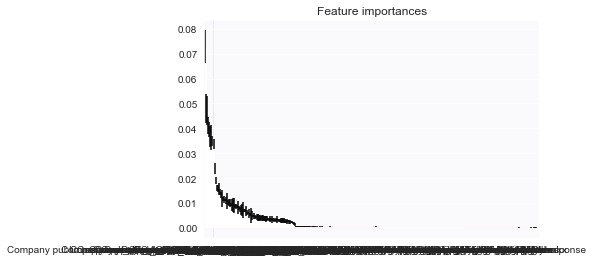

In [0]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, list(x_train.columns)[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), list(x_train.columns))
plt.xlim([-1, x_train.shape[1]])
plt.show()

    Trying with XG Boost

In [0]:
clf=XGBClassifier(objective='binary:logistic')
clf.fit(x_train,y_train)
predicted = clf.predict(x_test)

print('Accuracy Score is :' , accuracy_score(y_test,predicted))
print('Recall Score is :',recall_score(y_test,predicted))
print('Precision Score is :',precision_score(y_test,predicted))
print('Auc Score is : ', roc_auc_score(y_test,predicted))
print('Fbeta 2 Score is :', fbeta_score(predicted,y_test, average='macro', beta=2))
print(confusion_matrix(y_test, predicted, labels=None, sample_weight=None))

Accuracy Score is : 0.5889013369183658
Recall Score is : 0.6610301147227533
Precision Score is : 0.5776872666510012
Auc Score is :  0.5889024143356544
Fbeta 2 Score is : 0.5884147787804286
[[17298 16175]
 [11346 22126]]


Hyperparamter Tunning for XG Boost

In [0]:
clf=XGBClassifier(objective='binary:logistic')

In [0]:
param_dist = {
              "max_depth": [10,20],
              "learning_rate":[0.01,0.05],
                "min_child_weight":[5],
              "subsample":[i/10.0 for i in range(8,10)],
             "colsample_bytree":[i/10.0 for i in range(8,10)],
               "reg_alpha":[1e-5, 1e-2, 0.1],
              "gamma":[i/10.0 for i in range(4,5)],
                "n_estimators":[700,1000],
                'scale_pos_weight':[2,3]
              }


In [0]:
n_iter=3

random_search=RandomizedSearchCV(clf,n_jobs=-1,verbose=2,cv=5,n_iter=n_iter,scoring='roc_auc',
                                 param_distributions=param_dist)

In [0]:
report(random_search.cv_results_,5)

In [0]:
xgb_best=XGBClassifier(subsample=0.8,scale_pos_weight=3,reg_alpha=1e-05,n_estimators=700,min_child_weight=4,
                       max_depth=4,learning_rate=0.05,gamma=0.3,colsample_bytree=0.8
                      )

In [0]:
xgb_best.fit(x_train,y_train)

predicted = xgb_best.predict(x_test)
print('Accuracy Score is :' , accuracy_score(y_test,predicted))
print('Recall Score is :',recall_score(y_test,predicted))
print('Precision Score is :',precision_score(y_test,predicted))
print('Auc Score is : ', roc_auc_score(y_test,predicted))
print('Fbeta 2 Score is :', fbeta_score(predicted,y_test, average='macro', beta=2))
print(confusion_matrix(y_test, predicted, labels=None, sample_weight=None))

Finding out the correct probabilty cutoff to predict hard classess

In [0]:
cutoffs=np.linspace(0.01,0.99,99)
cutoffs

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [0]:
train_score=clf.predict_proba(x_train)[:,1] # the predicted response variable values
real=y_train # the actual response variable values
print(clf.classes_) # In order to find the probability of which column is for outcome 1 and which for outcome 0

[0. 1.]


In [0]:
from sklearn.metrics import fbeta_score

In [0]:
KS_all=[]
for cutoff in cutoffs:
    predicted=(train_score>cutoff).astype(int)
    
    TP=((predicted==1) & (real==1)).sum()
    TN=((predicted==0) & (real==0)).sum()
    FP=((predicted==1) & (real==0)).sum()
    FN=((predicted==0) & (real==1)).sum()
    
    P=TP+FN
    N=TN+FP
    KS=(TP/P)-(FP/N)
    KS_all.append(KS)
    
# try out what cutoffs you get when you use F_beta scores with different values of betas [0.5 , 5]
# beta < 1 : you will get cutoff , which is high ( favours precision)
# beta > 1 : you will get cutoff , which is low (favours precision )

In [0]:
#list(zip(cutoffs,KS_all))

[(0.01, 0.0),
 (0.02, 0.0),
 (0.03, 0.0),
 (0.04, 0.0),
 (0.05, 0.0),
 (0.060000000000000005, 0.0),
 (0.06999999999999999, 0.0),
 (0.08, 0.0),
 (0.09, 0.0),
 (0.09999999999999999, 0.0),
 (0.11, 0.0),
 (0.12, 0.0),
 (0.13, 0.0),
 (0.14, 0.0),
 (0.15000000000000002, 1.4714971011464684e-05),
 (0.16, 0.00010300479708058585),
 (0.17, 0.0003531595208033922),
 (0.18000000000000002, 0.0008534687517217643),
 (0.19, 0.0018982325596476057),
 (0.2, 0.003001859716054267),
 (0.21000000000000002, 0.004002480776217343),
 (0.22, 0.00644517765659558),
 (0.23, 0.008284560075920488),
 (0.24000000000000002, 0.00956476710099241),
 (0.25, 0.012095749476896067),
 (0.26, 0.016745698937870146),
 (0.27, 0.02510383906550062),
 (0.28, 0.033094122023491046),
 (0.29000000000000004, 0.04179073831388247),
 (0.3, 0.053724694563623054),
 (0.31, 0.06554092498251052),
 (0.32, 0.07366366173399674),
 (0.33, 0.08581835337526933),
 (0.34, 0.10203443742680274),
 (0.35000000000000003, 0.11360058370982984),
 (0.36000000000000004

In [0]:
mycutoff=cutoffs[KS_all==max(KS_all)][0]
mycutoff # gives the cutoff value where KS is maximum

0.51

In [0]:
test_score=clf.predict_proba(cd_test)[:,1]
test_score

array([0.5649128 , 0.52992064, 0.6269907 , ..., 0.36371216, 0.3607114 ,
       0.52012265], dtype=float32)

In [0]:
test_classes=(test_score>mycutoff).astype(int)
print(test_classes)

[1 1 1 ... 0 0 1]


In [0]:
len(test_classes)

In [0]:
pd.DataFrame(test_classes).to_csv("Project1_Part2_0.2.csv",index=False)
# Please give the file a proper name before submission